In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np
import math


import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import set_config
from sklearn.metrics import f1_score
import lightgbm as lgb
set_config(display='diagram') # Để trực quan hóa pipeline

# You can also import other things ...
# YOUR CODE HERE (OPTION)

## Thông tin bảng

In [2]:
data_df = pd.read_csv('practice_data.csv', index_col=0).reset_index(drop=True)
data_df.head(5)

,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_measurement_major_defect_rate_60,factory_product_measurement_major_defect_rate_90,factory_product_measurement_major_defect_rate_120,factory_product_measurement_major_defect_rate_150,factory_product_measurement_minor_defect_rate_30,factory_product_measurement_minor_defect_rate_60,factory_product_measurement_minor_defect_rate_90,factory_product_measurement_minor_defect_rate_120,factory_product_measurement_minor_defect_rate_150,label
0,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.0,0.032258,0.028571,0.027778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.0,0.200000,0.035714,0.020408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,c0bffcf0318c483b2dbb1c56bed6efa58f9717bd,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,8,NaN,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.0,0.000000,0.000000,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
data_df.shape

(13293, 155)

## Phân tích dữ liệu

## Tách train/validation/test: 72/18/10

In [4]:
# Tách X và y
y_sr = data_df["label"] # sr là viết tắt của series
X_df = data_df.drop("label", axis=1)

# train /  test
X_df, test_df, y_sr, test_sr = train_test_split(X_df, y_sr, test_size=0.1, 
                                                              stratify=y_sr, random_state=15)
# train / val
X_df, val_df, y_sr, val_sr = train_test_split(X_df, y_sr, test_size=0.2, 
                                                              stratify=y_sr, random_state=15)

In [5]:
X_df.shape, val_df.shape, test_df.shape

((9570, 154), (2393, 154), (1330, 154))

### Cột object

In [6]:
obj_cols = list(data_df.dtypes[data_df.dtypes == object].index)
obj_cols

['hashed_factory_id',
 'country',
 'hashed_type_of_inspection',
 'style_number',
 'item_number',
 'brand_number',
 'hashed_product_line',
 'hashed_product_category',
 'hashed_product_id']

In [7]:
obj_cols = [
 'hashed_factory_id',
 'country',
 'hashed_type_of_inspection',
 'style_number',
 'item_number',
 'brand_number', #bor
 'hashed_product_line', #bor
 'hashed_product_category',
 'hashed_product_id'
 ]
#data_df.drop(columns=obj_cols, inplace=True)

## Điền giá trị missing, chuyển cột object sang number và chuẩn hóa

In [8]:
unorder_cate_cols = obj_cols

#unorder_cate_cols = []

mode_ordercols = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
mode_unordercols = make_pipeline(mode_ordercols, OneHotEncoder(handle_unknown='ignore'))

col_transform = ColumnTransformer([('unorder_cate_cols', mode_unordercols, unorder_cate_cols)],remainder='passthrough')
scale = StandardScaler(with_mean=False)
preprocess_pipeline = make_pipeline(col_transform, scale)



#X_df = preprocess_pipeline.fit_transform(X_df)
#test_df = preprocess_pipeline.transform(test_df)
#val_df = preprocess_pipeline.transform(val_df)

## Oversampling Technique (SMOTE) (optional)

In [9]:
#Oversampling Technique (SMOTE)
#from imblearn.over_sampling import SMOTE
#smote = SMOTE()
#X_df, y_sr = smote.fit_resample(X_df, y_sr)

## Mô hình Light Gradient Boosting, phạt mô hình cho mất cân bằng dữ liệu

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier


clf = lgb.LGBMClassifier(num_leaves = 30, n_estimators=150, class_weight={0: 1.5, 1: 5.5}, random_state = 15)  #Phạt mô hình ở class_weight
#clf = BaggingClassifier(base_estimator=clf, n_estimators=10, random_state = 10)
clf = make_pipeline(preprocess_pipeline, clf)
#clf = make_pipeline(clf)
#score = cross_val_score(clf , X = X_df, y = y_sr, cv=5, scoring='f1_weighted')
#score.mean()

In [11]:
clf.fit(X_df, y_sr)
print(f1_score(val_sr, clf.predict(val_df), average='weighted'))

0.9347661924367291


## Val Metric

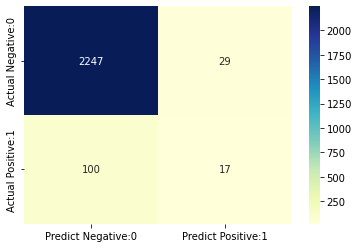

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_sr, clf.predict(val_df))
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
_ = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Test Metric

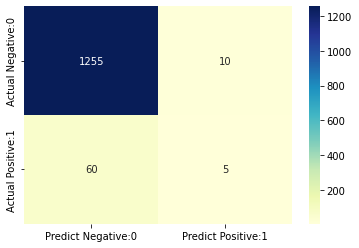

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_sr, clf.predict(test_df))
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])

_ = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')